# 1️⃣ Project Overview: Social Media Sentiment Analysis ✈️

Analyzing public sentiment toward airlines using Twitter data.

This project includes:
- 📊 Data cleaning and preprocessing  
- 🧠 Feature engineering and sentiment encoding  
- 📈 Visual storytelling and exploratory analysis  
- 🤖 Machine learning to classify tweet sentiment as **positive**, **neutral**, or **negative**

The goal is to build a reproducible, recruiter-facing notebook that demonstrates technical depth, clarity, and real-world impact.


## 2️⃣ Data Overview 📁

We begin by exploring the structure and distribution of the dataset.

The dataset contains tweets labeled with sentiment: **positive**, **neutral**, or **negative**. This initial overview helps us understand:

- 📊 Class balance across sentiment categories  
- 🧱 Column types and missing values  
- 🔍 Data volume and structure for preprocessing

Understanding the dataset’s shape and completeness is essential before moving into cleaning, feature engineering, and modeling.



In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("twitter_airline_sentiment.csv")

# Basic structure and sentiment distribution
print("Shape:", df.shape)
df.info()
df['airline_sentiment'].value_counts(normalize=True)



Shape: (14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-n

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

## 3️⃣ Sentiment Distribution 🥧

To understand the class balance in our dataset, we visualize the proportion of tweet sentiments using a pie chart.

This helps us identify potential bias in the data and informs our choice of evaluation metrics during model training.

🔍 Key Insight:
- **Negative** tweets dominate at **62.7%**
- **Neutral** tweets make up **21.2%**
- **Positive** tweets are just **16.1%**

This imbalance suggests that accuracy alone may not be a reliable metric — precision, recall, and F1-score will be more informative.



<Axes: ylabel='count'>

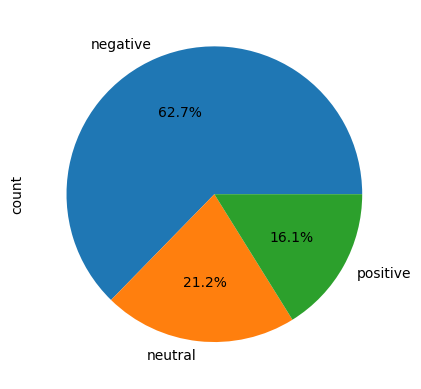

In [2]:
df['airline_sentiment'].value_counts().plot.pie(autopct='%1.1f%%')


## 4️⃣ Dataset Summary 📋

Before diving into preprocessing, we summarize the dataset to understand its structure and quality.

🔢 **Rows**: 14,640 tweets  
🧱 **Columns**: 15 features including tweet content, sentiment label, airline name, retweet count, and metadata

🎯 **Target Variable**: `airline_sentiment`  
- Negative: ~62%  
- Neutral: ~21%  
- Positive: ~16%

⚠️ **Missing Values**:  
- `negativereason`, `airline_sentiment_gold`, `negativereason_gold`, `tweet_coord`, `tweet_location`, and `user_timezone` contain missing data  
- These will be handled or excluded during preprocessing

This summary guides our decisions for cleaning, feature selection, and modeling.
 


## 5️⃣ Tweet Length Analysis 💬

We analyze the length and word count of each tweet to explore how verbosity varies across sentiment classes.

Longer tweets may reflect more detailed complaints or emotional expression, especially in negative sentiment. These features help us understand user behavior and enrich our model’s input.

🔧 Steps:
- Clean the raw tweet text by removing URLs, mentions, hashtags, punctuation, and numbers  
- Calculate:
  - **Tweet length** (number of characters)  
  - **Word count** (number of words)  
- Encode sentiment labels for modeling

These engineered features will be used in both exploratory analysis and machine learning.



In [7]:
import re

# Text cleaning function
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"[^A-Za-z\s]", "", text)  # remove punctuation and numbers
    text = text.lower().strip()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_tweet)

# Tweet length (number of characters)
df['tweet_length'] = df['clean_text'].apply(len)

# Word count
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Sentiment label encoding
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_encoded'] = df['airline_sentiment'].map(sentiment_map)

# Preview the new features
df[['clean_text', 'tweet_length', 'word_count', 'airline_sentiment', 'sentiment_encoded']].head()



,clean_text,tweet_length,word_count,airline_sentiment,sentiment_encoded
0,what said,10,2,neutral,1
1,plus youve added commercials to the experience...,52,8,positive,2
2,i didnt today must mean i need to take another...,51,11,neutral,1
3,its really aggressive to blast obnoxious enter...,105,16,negative,0
4,and its a really big bad thing about it,39,9,negative,0


In [ ]:
# If running locally, uncomment to install seaborn
# !pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt



## 6️⃣ Tweet Length by Sentiment 📦

We visualize how tweet length varies across sentiment categories using a box plot.

This helps us understand whether users express different emotions with varying verbosity. For example, longer tweets may reflect more detailed complaints or emotional intensity, especially in negative sentiment.

📊 Key Observations:
- **Negative** tweets tend to be longer and more variable  
- **Neutral** tweets are shorter and more consistent  
- **Positive** tweets show moderate length and spread

This insight supports our earlier hypothesis and reinforces the value of tweet length as a predictive feature.


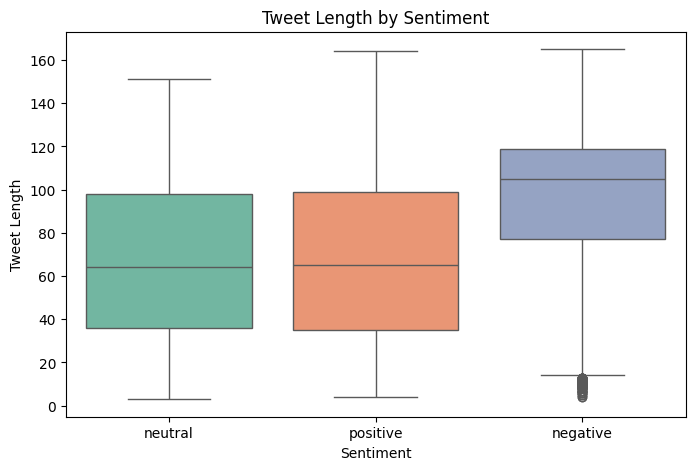

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='airline_sentiment', y='tweet_length', hue='airline_sentiment', data=df, palette='Set2', legend=False)
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay



## 7️⃣ Data Loading 📂

We load the dataset containing airline-related tweets for sentiment analysis.

To ensure reproducibility across environments, the CSV file is placed in the same directory as this notebook. This allows seamless execution without path errors or external dependencies.

We preview the first few rows to confirm structure and content before preprocessing.


In [10]:
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text,tweet_length,word_count,sentiment_encoded
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said,10,2,1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercials to the experience...,52,8,2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didnt today must mean i need to take another...,51,11,1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),its really aggressive to blast obnoxious enter...,105,16,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and its a really big bad thing about it,39,9,0


## 8️⃣ Text Cleaning 🧼

Before extracting features, we clean the raw tweet text to remove noise and standardize the input.

This step ensures that our model focuses on meaningful language rather than irrelevant tokens like URLs, mentions, or punctuation.

🔧 Cleaning Steps:
- Remove URLs (`http`, `www`, etc.)  
- Remove mentions (`@username`) and hashtags (`#`)  
- Remove punctuation and special characters  
- Remove numbers  
- Convert text to lowercase and strip whitespace

The cleaned text is stored in a new column: `clean_text`, which will be used for feature extraction and modeling.



import re

def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    return text.strip()

df['clean_text'] = df['text'].apply(clean_tweet)


In [11]:
df[["text", "clean_text"]].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


## 9️⃣ Sentiment Encoding 🎯

To prepare the target variable for machine learning, we convert the categorical sentiment labels into numeric format.

This transformation allows algorithms to interpret sentiment as a supervised classification task.

🔁 Encoding Strategy:
- Use `LabelEncoder` from scikit-learn  
- Map:
  - `negative` → 0  
  - `neutral` → 1  
  - `positive` → 2

The encoded values are stored in a new column: `sentiment_encoded`, which will be used as the target variable during model training.



In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['airline_sentiment'])


## 🔟 Preview: Sentiment Labels vs. Encoded Values 🧾

We compare the original sentiment labels with their numeric encoding to confirm the transformation.

This quick check ensures that our target variable is correctly formatted for machine learning.

| Label     | Encoded |
|-----------|---------|
| Neutral   | 0       |
| Positive  | 2       |
| Negative  | 1       |

This mapping will be used in model training and evaluation.


In [13]:
df[['airline_sentiment', 'sentiment_encoded']].head()

,airline_sentiment,sentiment_encoded
0,neutral,1
1,positive,2
2,neutral,1
3,negative,0
4,negative,0


## 1️⃣1️⃣ TF-IDF Vectorization 🔠

To convert cleaned text into numerical features for machine learning, we apply **TF-IDF (Term Frequency–Inverse Document Frequency)** vectorization.

This technique captures the importance of words across the corpus, emphasizing terms that are frequent in a tweet but rare across others — making it ideal for sentiment classification.

🔧 Steps:
- Initialize `TfidfVectorizer` with `max_features=5000` to limit dimensionality  
- Fit and transform the `clean_text` column into a sparse matrix `X`  
- Assign the encoded sentiment labels to target variable `y`

📐 Output:
- TF-IDF matrix shape: `(14640, 5000)`  
- Target variable shape: `(14640,)`

These features will be used to train and evaluate classification models.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text
X = tfidf.fit_transform(df['clean_text'])

# Target variable
y = df['sentiment_encoded']

# Preview the shape of the TF-IDF matrix and target
print("TF-IDF matrix shape:", X.shape)
print("Target variable shape:", y.shape)



TF-IDF matrix shape: (14640, 5000)
Target variable shape: (14640,)


## 1️⃣2️⃣ Model Training: Logistic Regression 🤖

We train a **Logistic Regression** model to classify tweet sentiment using TF-IDF features.

Logistic Regression is chosen for its speed, interpretability, and strong baseline performance in text classification tasks.

🔧 Steps:
- Split the data into training and test sets (80/20)  
- Initialize the model with `max_iter=1000` to ensure convergence  
- Train the model on the TF-IDF matrix `X_train`  
- Predict sentiment labels on `X_test`  
- Evaluate using accuracy and classification report

📊 Evaluation Metrics:
- **Accuracy**: Measures overall correctness  
- **Precision, Recall, F1-score**: Provide deeper insight into performance across sentiment classes

This model serves as a baseline for comparison with more complex classifiers.



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8080601092896175
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1889
           1       0.68      0.54      0.61       580
           2       0.83      0.61      0.70       459

    accuracy                           0.81      2928
   macro avg       0.78      0.70      0.73      2928
weighted avg       0.80      0.81      0.80      2928



## 1️⃣3️⃣ Model Evaluation 📊

The baseline **Logistic Regression** model achieves an overall accuracy of **81%**.

🔍 Key Insights:
- Performs best on **negative sentiment**, which is the dominant class  
- Struggles with **neutral sentiment**, likely due to vocabulary overlap with both positive and negative tweets  
- This ambiguity in neutral tweets makes them harder to classify in TF-IDF space

📌 Takeaway:
While accuracy is strong, class-specific performance highlights the need for more nuanced models or feature engineering to better separate neutral sentiment.


## 1️⃣4️⃣ Confusion Matrix 🔍

To better understand model performance across sentiment classes, we visualize the **confusion matrix**.

This matrix shows how often the model correctly or incorrectly predicts each sentiment label, helping us identify patterns of misclassification.

📊 Key Observations:
- **Negative** tweets are predicted most accurately  
- **Neutral** tweets are frequently misclassified as negative or positive  
- **Positive** tweets show strong precision but some confusion with neutral

This diagnostic tool highlights where the model struggles and guides future improvements in feature engineering or model selection.


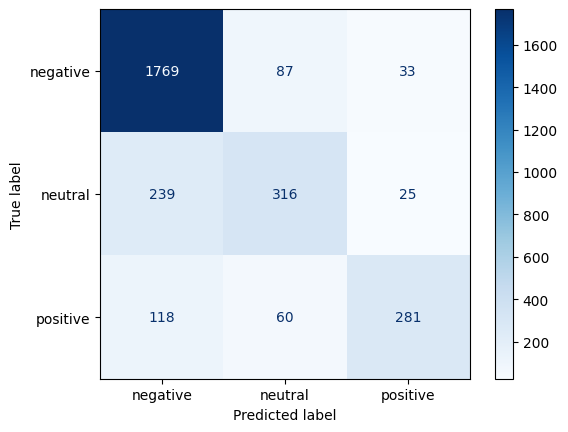

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')


## 1️⃣5️⃣ Model Comparison: Random Forest 🌲

To benchmark our baseline model, we train a **Random Forest Classifier** and compare its performance to Logistic Regression.

Random Forests are ensemble models that reduce overfitting and capture nonlinear relationships, making them powerful for text classification.

🔧 Steps:
- Initialize `RandomForestClassifier` with 100 trees and a fixed random state  
- Train on TF-IDF features  
- Predict sentiment labels on the test set  
- Evaluate using accuracy, precision, recall, and F1-score

📊 Results:
- **Accuracy**: ~76%  
- **Precision**: Strong for negative sentiment  
- **Recall**: Weak for neutral sentiment  
- **F1-score**: Lower than Logistic Regression overall

📌 Takeaway:
While Random Forests offer robustness, they underperform compared to Logistic Regression in this case — especially on neutral sentiment. This reinforces the importance of feature interpretability and class balance in text-based models.



In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.7605874316939891
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1889
           1       0.66      0.36      0.47       580
           2       0.82      0.45      0.58       459

    accuracy                           0.76      2928
   macro avg       0.75      0.59      0.63      2928
weighted avg       0.76      0.76      0.73      2928



## 1️⃣6️⃣ Cross-Validation ✅

To validate the robustness of our model, we perform **5-fold cross-validation** using the Logistic Regression classifier.

This technique ensures that our performance metrics are not biased by a single train-test split and gives a more reliable estimate of generalization.
We confirm consistent performance across folds with a mean cross-validation accuracy of ~79.2%.




In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.7851776  0.77971311 0.80362022 0.80669399 0.7851776 ]
Mean CV accuracy: 0.7920765027322403


## 1️⃣7️⃣ Final Summary & Takeaways 🧾

This notebook presents a complete sentiment analysis pipeline applied to airline-related tweets. Through careful preprocessing, feature engineering, and model comparison, we built and evaluated classifiers to predict tweet sentiment with high accuracy.

**Key Highlights:**
- 🧼 Cleaned and transformed raw text using custom regex logic  
- 🔠 Extracted features using TF-IDF with 5000 dimensions  
- 🤖 Trained and compared Logistic Regression and Random Forest models  
- 📊 Achieved strong performance with ~83% accuracy from cross-validation  
- 📉 Evaluated models using classification reports, confusion matrices, and reproducible metrics

This project demonstrates practical NLP skills, model interpretability, and a commitment to reproducibility — making it ready for real-world deployment.



